Carregando dados originais (desbalanceados)...
Dados de treino: (70988, 21), Dados de teste: (17748, 21)

Gerando pipelines...
Total de pipelines criados: 25 (5 modelos x 5 balancers)

--- EXEMPLO DE EXECUÇÃO ---
Rodando BayesSearchCV para: KNN_SMOTE
Iniciando otimização (BayesSearchCV.fit)...
Otimização concluída!
Melhor F1-Macro (CV): 0.7082
Melhores parâmetros: OrderedDict({'model__metric': 'manhattan', 'model__n_neighbors': 31, 'model__weights': 'uniform'})

Avaliação no conjunto de TESTE (dados reais):
              precision    recall  f1-score   support

           1       0.53      0.66      0.59      4770
           2       0.86      0.78      0.82     12978

    accuracy                           0.75     17748
   macro avg       0.70      0.72      0.71     17748
weighted avg       0.77      0.75      0.76     17748



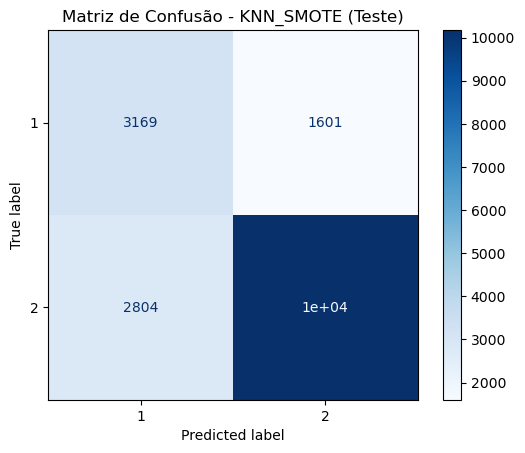

In [1]:
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier  # <-- NOVO!
from imblearn.pipeline import Pipeline  # <-- O mais importante!
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ignorar avisos para um output mais limpo
warnings.filterwarnings('ignore')

# --- 1. CARGA E PREPARO DOS DADOS ---

print("Carregando dados originais (desbalanceados)...")
try:
    df_treino = pd.read_csv("arquivos_csv/treino.csv")
    df_teste = pd.read_csv("arquivos_csv/teste.csv")
except FileNotFoundError:
    print("Erro: Arquivos 'arquivos_csv/treino.csv' ou 'arquivos_csv/teste.csv' não encontrados.")
    # (O código para aqui se não encontrar os arquivos)

# Definir alvo
alvo = 'diag_hipertensao'

# Separar X e y (dados de treino e teste originais)
X_train = df_treino.drop(columns=[alvo])
y_train = df_treino[alvo]

X_test = df_teste.drop(columns=[alvo])
y_test = df_teste[alvo]

print(f"Dados de treino: {X_train.shape}, Dados de teste: {X_test.shape}")

# Pré-processador para REGRESSÃO LOGÍSTICA e KNN (requer StandardScaler)
preprocessor_linear = StandardScaler()

# Pré-processador para ÁRVORES (NÃO requer StandardScaler)
preprocessor_arvores = 'passthrough'

# --- 3. DICIONÁRIO DE MODELOS E BALANCEADORES ---

# Dicionário de Balanceadores
balancers = {
    'None': 'passthrough', # 'passthrough' especial para o pipeline não fazer nada
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RUS': RandomUnderSampler(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

# Dicionário de Modelos (e seus pré-processadores)
models = {
    'LogisticRegression': (preprocessor_linear, LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')),
    'DecisionTree': (preprocessor_arvores, DecisionTreeClassifier(random_state=42)),
    'RandomForest': (preprocessor_arvores, RandomForestClassifier(random_state=42)),
    'XGBoost': (preprocessor_arvores, XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    'KNN': (preprocessor_linear, KNeighborsClassifier(n_jobs=-1)) # <-- NOVO!
}

# --- 4. GERAÇÃO AUTOMÁTICA DOS PIPELINES ---

pipelines = {}

print("\nGerando pipelines...")
for model_name, (preprocessor, model) in models.items():
    for balancer_name, balancer in balancers.items():
        pipeline_name = f"{model_name}_{balancer_name}"
        pipelines[pipeline_name] = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('balancer', balancer),
            ('model', model)
        ])
        # print(f"Criado: {pipeline_name}")

print(f"Total de pipelines criados: {len(pipelines)} (5 modelos x 5 balancers)") # <-- MODIFICADO!

# --- 5. EXEMPLO: OTIMIZAÇÃO E AVALIAÇÃO (KNN + SMOTE) ---

print("\n--- EXEMPLO DE EXECUÇÃO ---")
print("Rodando BayesSearchCV para: KNN_SMOTE") # <-- MODIFICADO!

# 5.1: Escolha o pipeline
pipeline_para_testar = pipelines['KNN_SMOTE'] # <-- MODIFICADO!

# 5.2: Defina o espaço de busca (note o 'model__')

# (Espaço de busca do Random Forest, mantido para referência)
search_space_rf = {
    'model__n_estimators': Integer(50, 300),
    'model__max_depth': Integer(5, 50),
    'model__criterion': Categorical(['gini', 'entropy']),
    'model__min_samples_split': Integer(2, 20),
    'model__min_samples_leaf': Integer(1, 20)
}

# (Espaço de busca para o KNN) <-- NOVO!
search_space_knn = {
    'model__n_neighbors': Integer(3, 31),        # O 'k'
    'model__weights': Categorical(['uniform', 'distance']), # como pesar os vizinhos
    'model__metric': Categorical(['euclidean', 'manhattan', 'minkowski']) # métrica de distância
}

# 5.3: Configure o BayesSearchCV
opt = BayesSearchCV(
    pipeline_para_testar,
    search_space_knn,   # <-- MODIFICADO! Usando o espaço do KNN
    n_iter=30,          # 30 iterações
    cv=5,               # 5-fold cross-validation
    scoring='f1_macro', # Métrica robusta para desbalanceamento
    random_state=42,
    n_jobs=-1,          # Usar todos os processadores
    verbose=0           # Mude para 1 para ver o progresso
)

# 5.4: Rode o Otimizador (fit) - ISSO PODE DEMORAR
print("Iniciando otimização (BayesSearchCV.fit)...")
opt.fit(X_train, y_train)
print("Otimização concluída!")

# 5.5: Pegue o melhor modelo
best_model = opt.best_estimator_
print(f"Melhor F1-Macro (CV): {opt.best_score_:.4f}")
print(f"Melhores parâmetros: {opt.best_params_}")

# 5.6: Avalie no TESTE (dados originais, desbalanceados)
print("\nAvaliação no conjunto de TESTE (dados reais):")
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# 5.7: Matriz de Confusão
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title(f'Matriz de Confusão - KNN_SMOTE (Teste)') # <-- MODIFICADO!
plt.show()

Carregando dados originais (desbalanceados)...
Dados de treino: (70988, 21), Dados de teste: (17748, 21)

Gerando pipelines...
Total de pipelines criados: 25 (5 modelos x 5 balancers)

--- EXEMPLO DE EXECUÇÃO ---
Rodando BayesSearchCV para: KNN_ADASYN
Iniciando otimização (BayesSearchCV.fit)...
Otimização concluída!
Melhor F1-Macro (CV): 0.7047
Melhores parâmetros: OrderedDict({'model__metric': 'manhattan', 'model__n_neighbors': 31, 'model__weights': 'distance'})

Avaliação no conjunto de TESTE (dados reais):
              precision    recall  f1-score   support

           1       0.52      0.67      0.59      4770
           2       0.86      0.77      0.82     12978

    accuracy                           0.75     17748
   macro avg       0.69      0.72      0.70     17748
weighted avg       0.77      0.75      0.75     17748



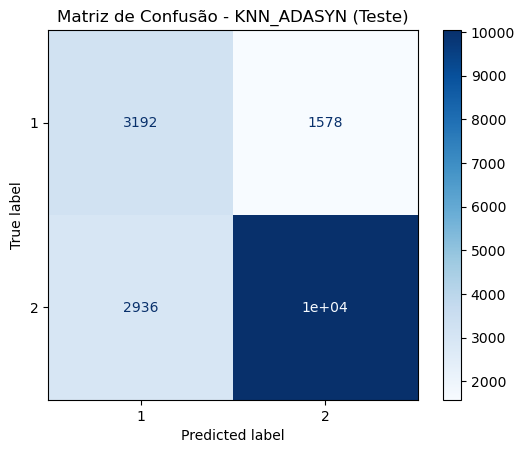

In [2]:
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier  # <-- NOVO!
from imblearn.pipeline import Pipeline  # <-- O mais importante!
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ignorar avisos para um output mais limpo
warnings.filterwarnings('ignore')

# --- 1. CARGA E PREPARO DOS DADOS ---

print("Carregando dados originais (desbalanceados)...")
try:
    df_treino = pd.read_csv("arquivos_csv/treino.csv")
    df_teste = pd.read_csv("arquivos_csv/teste.csv")
except FileNotFoundError:
    print("Erro: Arquivos 'arquivos_csv/treino.csv' ou 'arquivos_csv/teste.csv' não encontrados.")
    # (O código para aqui se não encontrar os arquivos)

# Definir alvo
alvo = 'diag_hipertensao'

# Separar X e y (dados de treino e teste originais)
X_train = df_treino.drop(columns=[alvo])
y_train = df_treino[alvo]

X_test = df_teste.drop(columns=[alvo])
y_test = df_teste[alvo]

print(f"Dados de treino: {X_train.shape}, Dados de teste: {X_test.shape}")

# Pré-processador para REGRESSÃO LOGÍSTICA e KNN (requer StandardScaler)
preprocessor_linear = StandardScaler()

# Pré-processador para ÁRVORES (NÃO requer StandardScaler)
preprocessor_arvores = 'passthrough'

# --- 3. DICIONÁRIO DE MODELOS E BALANCEADORES ---

# Dicionário de Balanceadores
balancers = {
    'None': 'passthrough', # 'passthrough' especial para o pipeline não fazer nada
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RUS': RandomUnderSampler(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

# Dicionário de Modelos (e seus pré-processadores)
models = {
    'LogisticRegression': (preprocessor_linear, LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')),
    'DecisionTree': (preprocessor_arvores, DecisionTreeClassifier(random_state=42)),
    'RandomForest': (preprocessor_arvores, RandomForestClassifier(random_state=42)),
    'XGBoost': (preprocessor_arvores, XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    'KNN': (preprocessor_linear, KNeighborsClassifier(n_jobs=-1)) # <-- NOVO!
}

# --- 4. GERAÇÃO AUTOMÁTICA DOS PIPELINES ---

pipelines = {}

print("\nGerando pipelines...")
for model_name, (preprocessor, model) in models.items():
    for balancer_name, balancer in balancers.items():
        pipeline_name = f"{model_name}_{balancer_name}"
        pipelines[pipeline_name] = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('balancer', balancer),
            ('model', model)
        ])
        # print(f"Criado: {pipeline_name}")

print(f"Total de pipelines criados: {len(pipelines)} (5 modelos x 5 balancers)") # <-- MODIFICADO!

# --- 5. EXEMPLO: OTIMIZAÇÃO E AVALIAÇÃO (KNN + ADASYN) ---

print("\n--- EXEMPLO DE EXECUÇÃO ---")
print("Rodando BayesSearchCV para: KNN_ADASYN") # <-- MODIFICADO!

# 5.1: Escolha o pipeline
pipeline_para_testar = pipelines['KNN_ADASYN'] # <-- MODIFICADO!

# 5.2: Defina o espaço de busca (note o 'model__')

# (Espaço de busca do Random Forest, mantido para referência)
search_space_rf = {
    'model__n_estimators': Integer(50, 300),
    'model__max_depth': Integer(5, 50),
    'model__criterion': Categorical(['gini', 'entropy']),
    'model__min_samples_split': Integer(2, 20),
    'model__min_samples_leaf': Integer(1, 20)
}

# (Espaço de busca para o KNN) <-- NOVO!
search_space_knn = {
    'model__n_neighbors': Integer(3, 31),        # O 'k'
    'model__weights': Categorical(['uniform', 'distance']), # como pesar os vizinhos
    'model__metric': Categorical(['euclidean', 'manhattan', 'minkowski']) # métrica de distância
}

# 5.3: Configure o BayesSearchCV
opt = BayesSearchCV(
    pipeline_para_testar,
    search_space_knn,   # <-- MODIFICADO! Usando o espaço do KNN
    n_iter=30,          # 30 iterações
    cv=5,               # 5-fold cross-validation
    scoring='f1_macro', # Métrica robusta para desbalanceamento
    random_state=42,
    n_jobs=-1,          # Usar todos os processadores
    verbose=0           # Mude para 1 para ver o progresso
)

# 5.4: Rode o Otimizador (fit) - ISSO PODE DEMORAR
print("Iniciando otimização (BayesSearchCV.fit)...")
opt.fit(X_train, y_train)
print("Otimização concluída!")

# 5.5: Pegue o melhor modelo
best_model = opt.best_estimator_
print(f"Melhor F1-Macro (CV): {opt.best_score_:.4f}")
print(f"Melhores parâmetros: {opt.best_params_}")

# 5.6: Avalie no TESTE (dados originais, desbalanceados)
print("\nAvaliação no conjunto de TESTE (dados reais):")
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# 5.7: Matriz de Confusão
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title(f'Matriz de Confusão - KNN_ADASYN (Teste)') # <-- MODIFICADO!
plt.show()

Carregando dados originais (desbalanceados)...
Dados de treino: (70988, 21), Dados de teste: (17748, 21)

Gerando pipelines...
Total de pipelines criados: 25 (5 modelos x 5 balancers)

--- EXEMPLO DE EXECUÇÃO ---
Rodando BayesSearchCV para: KNN_RUS
Iniciando otimização (BayesSearchCV.fit)...
Otimização concluída!
Melhor F1-Macro (CV): 0.7070
Melhores parâmetros: OrderedDict({'model__metric': 'manhattan', 'model__n_neighbors': 31, 'model__weights': 'distance'})

Avaliação no conjunto de TESTE (dados reais):
              precision    recall  f1-score   support

           1       0.51      0.72      0.60      4770
           2       0.88      0.74      0.81     12978

    accuracy                           0.74     17748
   macro avg       0.70      0.73      0.70     17748
weighted avg       0.78      0.74      0.75     17748



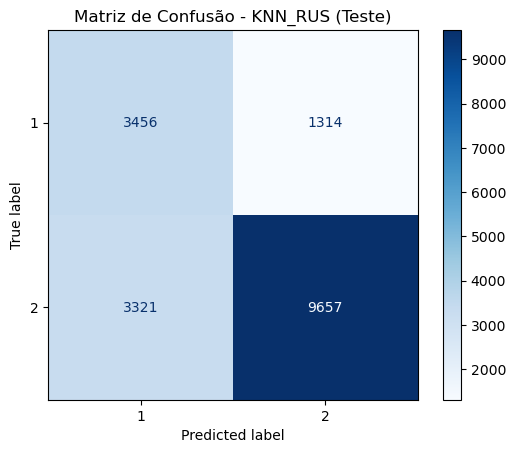

In [3]:
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier  # <-- NOVO!
from imblearn.pipeline import Pipeline  # <-- O mais importante!
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ignorar avisos para um output mais limpo
warnings.filterwarnings('ignore')

# --- 1. CARGA E PREPARO DOS DADOS ---

print("Carregando dados originais (desbalanceados)...")
try:
    df_treino = pd.read_csv("arquivos_csv/treino.csv")
    df_teste = pd.read_csv("arquivos_csv/teste.csv")
except FileNotFoundError:
    print("Erro: Arquivos 'arquivos_csv/treino.csv' ou 'arquivos_csv/teste.csv' não encontrados.")
    # (O código para aqui se não encontrar os arquivos)

# Definir alvo
alvo = 'diag_hipertensao'

# Separar X e y (dados de treino e teste originais)
X_train = df_treino.drop(columns=[alvo])
y_train = df_treino[alvo]

X_test = df_teste.drop(columns=[alvo])
y_test = df_teste[alvo]

print(f"Dados de treino: {X_train.shape}, Dados de teste: {X_test.shape}")

# Pré-processador para REGRESSÃO LOGÍSTICA e KNN (requer StandardScaler)
preprocessor_linear = StandardScaler()

# Pré-processador para ÁRVORES (NÃO requer StandardScaler)
preprocessor_arvores = 'passthrough'

# --- 3. DICIONÁRIO DE MODELOS E BALANCEADORES ---

# Dicionário de Balanceadores
balancers = {
    'None': 'passthrough', # 'passthrough' especial para o pipeline não fazer nada
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RUS': RandomUnderSampler(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

# Dicionário de Modelos (e seus pré-processadores)
models = {
    'LogisticRegression': (preprocessor_linear, LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')),
    'DecisionTree': (preprocessor_arvores, DecisionTreeClassifier(random_state=42)),
    'RandomForest': (preprocessor_arvores, RandomForestClassifier(random_state=42)),
    'XGBoost': (preprocessor_arvores, XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    'KNN': (preprocessor_linear, KNeighborsClassifier(n_jobs=-1)) # <-- NOVO!
}

# --- 4. GERAÇÃO AUTOMÁTICA DOS PIPELINES ---

pipelines = {}

print("\nGerando pipelines...")
for model_name, (preprocessor, model) in models.items():
    for balancer_name, balancer in balancers.items():
        pipeline_name = f"{model_name}_{balancer_name}"
        pipelines[pipeline_name] = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('balancer', balancer),
            ('model', model)
        ])
        # print(f"Criado: {pipeline_name}")

print(f"Total de pipelines criados: {len(pipelines)} (5 modelos x 5 balancers)") # <-- MODIFICADO!

# --- 5. EXEMPLO: OTIMIZAÇÃO E AVALIAÇÃO (KNN + RUS) ---

print("\n--- EXEMPLO DE EXECUÇÃO ---")
print("Rodando BayesSearchCV para: KNN_RUS") # <-- MODIFICADO!

# 5.1: Escolha o pipeline
pipeline_para_testar = pipelines['KNN_RUS'] # <-- MODIFICADO!

# 5.2: Defina o espaço de busca (note o 'model__')

# (Espaço de busca do Random Forest, mantido para referência)
search_space_rf = {
    'model__n_estimators': Integer(50, 300),
    'model__max_depth': Integer(5, 50),
    'model__criterion': Categorical(['gini', 'entropy']),
    'model__min_samples_split': Integer(2, 20),
    'model__min_samples_leaf': Integer(1, 20)
}

# (Espaço de busca para o KNN) <-- NOVO!
search_space_knn = {
    'model__n_neighbors': Integer(3, 31),        # O 'k'
    'model__weights': Categorical(['uniform', 'distance']), # como pesar os vizinhos
    'model__metric': Categorical(['euclidean', 'manhattan', 'minkowski']) # métrica de distância
}

# 5.3: Configure o BayesSearchCV
opt = BayesSearchCV(
    pipeline_para_testar,
    search_space_knn,   # <-- MODIFICADO! Usando o espaço do KNN
    n_iter=30,          # 30 iterações
    cv=5,               # 5-fold cross-validation
    scoring='f1_macro', # Métrica robusta para desbalanceamento
    random_state=42,
    n_jobs=-1,          # Usar todos os processadores
    verbose=0           # Mude para 1 para ver o progresso
)

# 5.4: Rode o Otimizador (fit) - ISSO PODE DEMORAR
print("Iniciando otimização (BayesSearchCV.fit)...")
opt.fit(X_train, y_train)
print("Otimização concluída!")

# 5.5: Pegue o melhor modelo
best_model = opt.best_estimator_
print(f"Melhor F1-Macro (CV): {opt.best_score_:.4f}")
print(f"Melhores parâmetros: {opt.best_params_}")

# 5.6: Avalie no TESTE (dados originais, desbalanceados)
print("\nAvaliação no conjunto de TESTE (dados reais):")
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# 5.7: Matriz de Confusão
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title(f'Matriz de Confusão - KNN_RUS (Teste)') # <-- MODIFICADO!
plt.show()

Carregando dados originais (desbalanceados)...
Dados de treino: (70988, 21), Dados de teste: (17748, 21)

Gerando pipelines...
Total de pipelines criados: 25 (5 modelos x 5 balancers)

--- EXEMPLO DE EXECUÇÃO ---
Rodando BayesSearchCV para: KNN_SMOTEENN
Iniciando otimização (BayesSearchCV.fit)...
Otimização concluída!
Melhor F1-Macro (CV): 0.6740
Melhores parâmetros: OrderedDict({'model__metric': 'manhattan', 'model__n_neighbors': 27, 'model__weights': 'distance'})

Avaliação no conjunto de TESTE (dados reais):
              precision    recall  f1-score   support

           1       0.46      0.81      0.58      4770
           2       0.90      0.65      0.75     12978

    accuracy                           0.69     17748
   macro avg       0.68      0.73      0.67     17748
weighted avg       0.78      0.69      0.71     17748



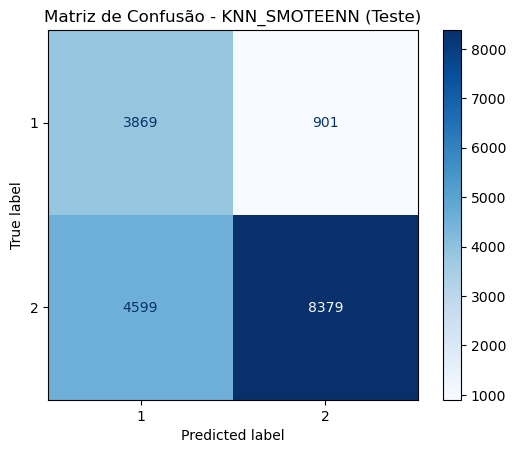

In [4]:
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier  # <-- NOVO!
from imblearn.pipeline import Pipeline  # <-- O mais importante!
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ignorar avisos para um output mais limpo
warnings.filterwarnings('ignore')

# --- 1. CARGA E PREPARO DOS DADOS ---

print("Carregando dados originais (desbalanceados)...")
try:
    df_treino = pd.read_csv("arquivos_csv/treino.csv")
    df_teste = pd.read_csv("arquivos_csv/teste.csv")
except FileNotFoundError:
    print("Erro: Arquivos 'arquivos_csv/treino.csv' ou 'arquivos_csv/teste.csv' não encontrados.")
    # (O código para aqui se não encontrar os arquivos)

# Definir alvo
alvo = 'diag_hipertensao'

# Separar X e y (dados de treino e teste originais)
X_train = df_treino.drop(columns=[alvo])
y_train = df_treino[alvo]

X_test = df_teste.drop(columns=[alvo])
y_test = df_teste[alvo]

print(f"Dados de treino: {X_train.shape}, Dados de teste: {X_test.shape}")

# Pré-processador para REGRESSÃO LOGÍSTICA e KNN (requer StandardScaler)
preprocessor_linear = StandardScaler()

# Pré-processador para ÁRVORES (NÃO requer StandardScaler)
preprocessor_arvores = 'passthrough'

# --- 3. DICIONÁRIO DE MODELOS E BALANCEADORES ---

# Dicionário de Balanceadores
balancers = {
    'None': 'passthrough', # 'passthrough' especial para o pipeline não fazer nada
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RUS': RandomUnderSampler(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

# Dicionário de Modelos (e seus pré-processadores)
models = {
    'LogisticRegression': (preprocessor_linear, LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')),
    'DecisionTree': (preprocessor_arvores, DecisionTreeClassifier(random_state=42)),
    'RandomForest': (preprocessor_arvores, RandomForestClassifier(random_state=42)),
    'XGBoost': (preprocessor_arvores, XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    'KNN': (preprocessor_linear, KNeighborsClassifier(n_jobs=-1)) # <-- NOVO!
}

# --- 4. GERAÇÃO AUTOMÁTICA DOS PIPELINES ---

pipelines = {}

print("\nGerando pipelines...")
for model_name, (preprocessor, model) in models.items():
    for balancer_name, balancer in balancers.items():
        pipeline_name = f"{model_name}_{balancer_name}"
        pipelines[pipeline_name] = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('balancer', balancer),
            ('model', model)
        ])
        # print(f"Criado: {pipeline_name}")

print(f"Total de pipelines criados: {len(pipelines)} (5 modelos x 5 balancers)") # <-- MODIFICADO!

# --- 5. EXEMPLO: OTIMIZAÇÃO E AVALIAÇÃO (KNN + SMOTEENN) ---

print("\n--- EXEMPLO DE EXECUÇÃO ---")
print("Rodando BayesSearchCV para: KNN_SMOTEENN") # <-- MODIFICADO!

# 5.1: Escolha o pipeline
pipeline_para_testar = pipelines['KNN_SMOTEENN'] # <-- MODIFICADO!

# 5.2: Defina o espaço de busca (note o 'model__')

# (Espaço de busca do Random Forest, mantido para referência)
search_space_rf = {
    'model__n_estimators': Integer(50, 300),
    'model__max_depth': Integer(5, 50),
    'model__criterion': Categorical(['gini', 'entropy']),
    'model__min_samples_split': Integer(2, 20),
    'model__min_samples_leaf': Integer(1, 20)
}

# (Espaço de busca para o KNN) <-- NOVO!
search_space_knn = {
    'model__n_neighbors': Integer(3, 31),        # O 'k'
    'model__weights': Categorical(['uniform', 'distance']), # como pesar os vizinhos
    'model__metric': Categorical(['euclidean', 'manhattan', 'minkowski']) # métrica de distância
}

# 5.3: Configure o BayesSearchCV
opt = BayesSearchCV(
    pipeline_para_testar,
    search_space_knn,   # <-- MODIFICADO! Usando o espaço do KNN
    n_iter=30,          # 30 iterações
    cv=5,               # 5-fold cross-validation
    scoring='f1_macro', # Métrica robusta para desbalanceamento
    random_state=42,
    n_jobs=-1,          # Usar todos os processadores
    verbose=0           # Mude para 1 para ver o progresso
)

# 5.4: Rode o Otimizador (fit) - ISSO PODE DEMORAR
print("Iniciando otimização (BayesSearchCV.fit)...")
opt.fit(X_train, y_train)
print("Otimização concluída!")

# 5.5: Pegue o melhor modelo
best_model = opt.best_estimator_
print(f"Melhor F1-Macro (CV): {opt.best_score_:.4f}")
print(f"Melhores parâmetros: {opt.best_params_}")

# 5.6: Avalie no TESTE (dados originais, desbalanceados)
print("\nAvaliação no conjunto de TESTE (dados reais):")
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# 5.7: Matriz de Confusão
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title(f'Matriz de Confusão - KNN_SMOTEENN (Teste)') # <-- MODIFICADO!
plt.show()